In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df_customers = pd.read_csv('dim_customer.csv')
df_delivery_partners = pd.read_csv('dim_delivery_partner_.csv')
df_menu_items = pd.read_csv('dim_menu_item.csv')
df_restaurants = pd.read_csv('dim_restaurant.csv')
df_delivery_performance = pd.read_csv('fact_delivery_performance.csv')
df_order_item = pd.read_csv('fact_order_items.csv')
df_orders = pd.read_csv('fact_orders.csv')
df_ratings = pd.read_csv('fact_ratings.csv')

In [3]:
# Merge orders with customers
df_orders_master = df_orders.merge(df_customers, on='customer_id', how='left')

# Merge with restaurants
df_orders_master = df_orders_master.merge(df_restaurants, on='restaurant_id', how='left')

# Merge with delivery performance
df_orders_master = df_orders_master.merge(df_delivery_performance, on='order_id', how='left')

# Merge with ratings
df_orders_master = df_orders_master.merge(df_ratings[['order_id', 'rating', 'review_text', 'sentiment_score']], on='order_id', how='left')

In [4]:
# Merge order items with menu items
df_order_items_master = df_order_item.merge(df_menu_items, on='menu_item_id', how='left')

In [5]:
df_orders_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149166 entries, 0 to 149165
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     149166 non-null  object 
 1   customer_id                  149166 non-null  object 
 2   restaurant_id                149166 non-null  object 
 3   delivery_partner_id          143531 non-null  object 
 4   order_timestamp              149166 non-null  object 
 5   subtotal_amount              149166 non-null  float64
 6   discount_amount              149166 non-null  float64
 7   delivery_fee                 149166 non-null  float64
 8   total_amount                 149166 non-null  float64
 9   is_cod                       149166 non-null  object 
 10  is_cancelled                 149166 non-null  object 
 11  signup_date                  144113 non-null  object 
 12  city_x                       144113 non-null  object 
 13 

In [6]:
# Rename columns for clarity
df_orders_master.rename(columns={
    'city_x': 'customer_city',
    'city_y': 'restaurant_city',
    'avg_prep_time_min': 'avg_prep_time',
}, inplace=True)

df_order_items_master.rename(columns={
    'restaurant_id_x': 'restaurant_id',
    'restaurant_id_y': 'restaurant_id_menu',
}, inplace=True)

In [7]:
df_order_items_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342994 entries, 0 to 342993
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   order_id            342994 non-null  object 
 1   item_id             342994 non-null  object 
 2   menu_item_id        342994 non-null  object 
 3   restaurant_id       342994 non-null  object 
 4   quantity            342994 non-null  int64  
 5   unit_price          342994 non-null  float64
 6   item_discount       342994 non-null  float64
 7   line_total          342994 non-null  float64
 8   restaurant_id_menu  342994 non-null  object 
 9   item_name           342994 non-null  object 
 10  category            342994 non-null  object 
 11  is_veg              342994 non-null  object 
 12  price               342994 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 34.0+ MB


In [8]:
# Check for nulls
print(df_orders_master.isnull().sum())
print(df_order_items_master.isnull().sum())

# Convert timestamps
df_orders_master['order_timestamp'] = pd.to_datetime(df_orders_master['order_timestamp'])
df_orders_master['signup_date'] = pd.to_datetime(df_orders_master['signup_date'])

# Create delivery delay metric
df_orders_master['delivery_delay_mins'] = df_orders_master['actual_delivery_time_mins'] - df_orders_master['expected_delivery_time_mins']

order_id                           0
customer_id                        0
restaurant_id                      0
delivery_partner_id             5635
order_timestamp                    0
subtotal_amount                    0
discount_amount                    0
delivery_fee                       0
total_amount                       0
is_cod                             0
is_cancelled                       0
signup_date                     5053
customer_city                   5053
acquisition_channel             5053
restaurant_name                    0
restaurant_city                    0
cuisine_type                       0
partner_type                       0
avg_prep_time                      0
is_active                          0
actual_delivery_time_mins          0
expected_delivery_time_mins        0
distance_km                        0
rating                         80341
review_text                    80341
sentiment_score                80341
dtype: int64
order_id              0
i

/tmp/ipykernel_124/1944452190.py:7: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_orders_master['signup_date'] = pd.to_datetime(df_orders_master['signup_date'])


In [9]:
df_orders_master['customer_city'].fillna('Unknown', inplace=True)
df_orders_master['acquisition_channel'].fillna('Unknown', inplace=True)
df_orders_master['review_text'].fillna('Unknown', inplace=True)

In [10]:
df_orders_master.duplicated(subset= 'order_id').sum()

0

# Customer Recovery Segmentation

In [11]:
pre_crisis_end = pd.to_datetime('2025-05-31')
crisis_end = pd.to_datetime('2025-09-30')

df_orders_master['order_timestamp'] = pd.to_datetime(df_orders_master['order_timestamp'])

df_orders_master['phase'] = df_orders_master['order_timestamp'].apply(
    lambda x: 'pre_crisis' if x <= pre_crisis_end 
    else 'crisis' if x <= crisis_end 
    else 'recovery')

#### RFM Analysis

In [12]:
from datetime import datetime

snapshot_date = df_orders_master['order_timestamp'].max()

rfm = df_orders_master.groupby('customer_id').agg({
    'order_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count',
    'total_amount': 'sum'
}).rename(columns={
    'order_timestamp': 'recency',
    'order_id': 'frequency',
    'total_amount': 'monetary'
})

#### Customer Segments

In [13]:
rfm['R_score'] = pd.qcut(rfm['recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_score'] = pd.qcut(rfm['monetary'], 4, labels=[1,2,3,4])
rfm['segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

#### Behavioural Flags

In [14]:
df_orders_master['has_review'] = df_orders_master['review_text'].notnull().astype(int)

df_orders_master['responded_in_recovery'] = (
    (df_orders_master['phase'] == 'recovery') & 
    (df_orders_master['has_review'] == 1)
).astype(int)

acq_dummies = pd.get_dummies(df_orders_master['acquisition_channel'], prefix='acq')
df_orders_master = pd.concat([df_orders_master, acq_dummies], axis=1)

#### Segment Distribution

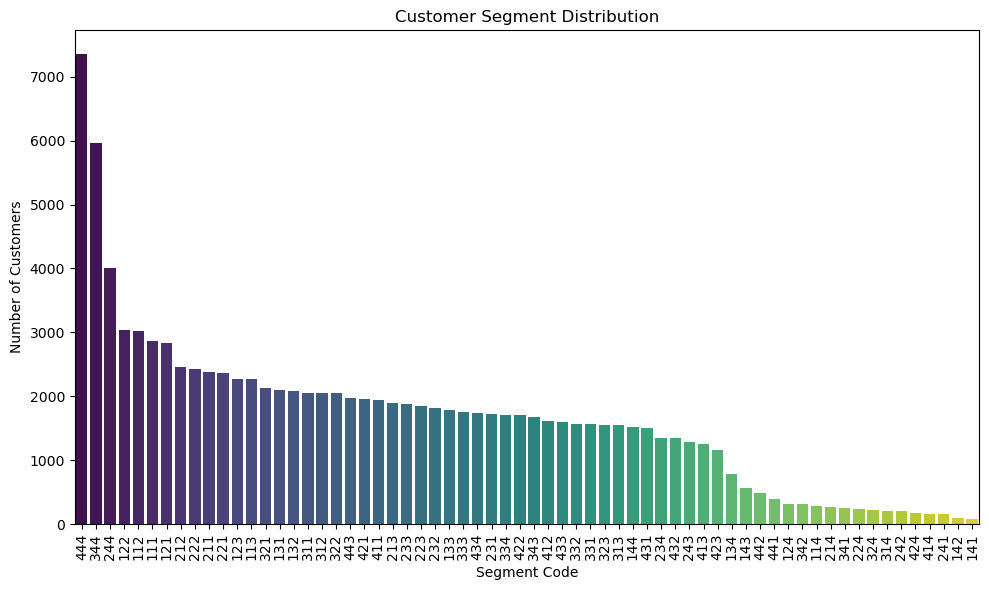

In [15]:
segment_counts = rfm['segment'].value_counts()

# Bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Segment Distribution')
plt.xlabel('Segment Code')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

What the Segment Codes Mean
Each digit in the segment code corresponds to a score:
- First digit: Recency score (how recently they ordered)
- Second digit: Frequency score (how often they ordered)
- Third digit: Monetary score (how much they spent)

What the Chart Tells You
- Tall bars: Segments with the most customers. These are your dominant behavioural groups.
- Short bars: Niche or rare segments—either new users, churned users, or outliers.
- Colour gradient: Helps visually differentiate segments but does not imply performance unless mapped to a metric.

Targeted Strategy Ideas:
- High Recency + High Monetary (e.g., 414) → Loyal but infrequent: Offer frequency-based rewards.
- Low Recency + Low Frequency (e.g., 111) → Lost customers: Run win-back campaigns.
- High Frequency + Low Monetary (e.g., 121) → Frequent but low spenders: Upsell or bundle offers.
- High Monetary + Low Frequency (e.g., 114) → Big spenders who rarely order: Personalised re-engagement.

#### Heatmap of RFM Scores

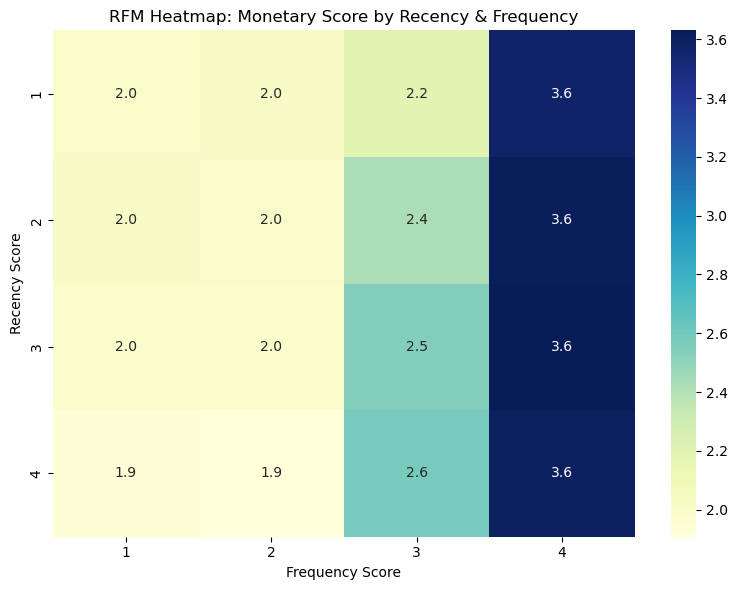

In [16]:
rfm['R_score'] = rfm['R_score'].astype(int)
rfm['F_score'] = rfm['F_score'].astype(int)
rfm['M_score'] = rfm['M_score'].astype(int)

rfm_heatmap = rfm.groupby(['R_score', 'F_score'])['M_score'].mean().unstack()

plt.figure(figsize=(8,6))
sns.heatmap(rfm_heatmap, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('RFM Heatmap: Monetary Score by Recency & Frequency')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.tight_layout()
plt.show()

What the Axes Represent

Vertical Axis (Recency Score):
- Score ranges from 1 (least recent) to 4 (most recent).
- Higher scores mean the customer ordered more recently.

Horizontal Axis (Frequency Score):
- Score ranges from 1 (least frequent) to 3 (most frequent).
- Higher scores mean the customer orders more often.

Cell Values (Monetary Score):
- These are average scores based on how much customers spend.
- Higher values (e.g., 3.6) indicate high spenders.

Key Insights from RFM Heatmap

| Recency Score | Frequency Score | Monetary Score | Interpretation                                                                 |
|---------------|------------------|----------------|--------------------------------------------------------------------------------|
| 4             | 3                | 3.6            | Most valuable customers—order often, recently, and spend a lot.               |
| 1             | 1                | 2.0            | Likely churned or disengaged—low frequency, old orders, low spend.            |
| 1             | 3                | 3.6            | Frequent but inactive recently—strong candidates for re-engagement campaigns. |
| 4             | 1                | 1.9            | New or one-time customers—recent but low frequency and spend.                 |

Strategic Takeaways
- Focus retention efforts on (4,3) and (3,3) segments—they’re loyal and high-value.
- Win-back campaigns for (1,3) and (2,3)—they used to order often but haven’t recently.
- Upsell or bundle offers for (4,1)—they’re new but might be nurtured into loyal users.
- Let go or deprioritise (1,1) and (2,1)—low engagement and low value.

#### Acquisition Channel vs. Recovery Likelihood

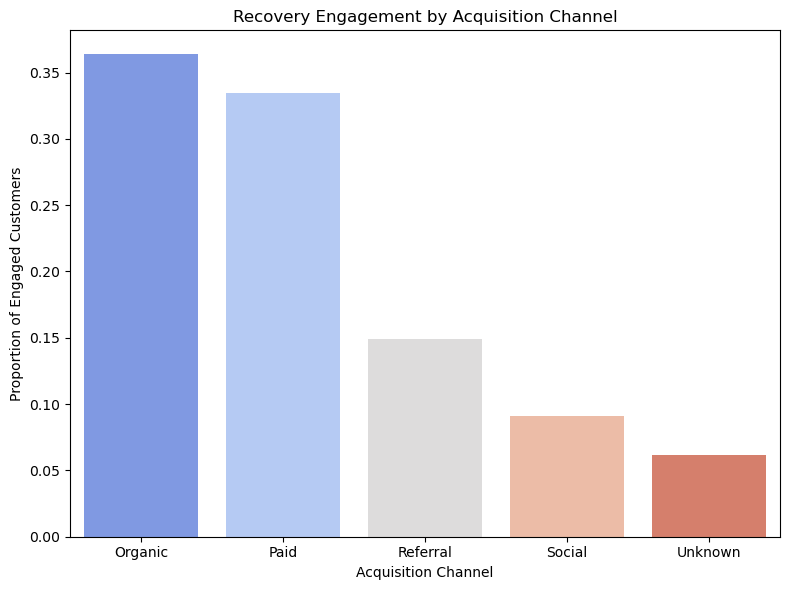

In [17]:
recovery_engagement = df_orders_master[df_orders_master['responded_in_recovery'] == 1]
channel_counts = recovery_engagement['acquisition_channel'].value_counts(normalize=True)

plt.figure(figsize=(8,6))
sns.barplot(x=channel_counts.index, y=channel_counts.values, palette='coolwarm')
plt.title('Recovery Engagement by Acquisition Channel')
plt.ylabel('Proportion of Engaged Customers')
plt.xlabel('Acquisition Channel')
plt.tight_layout()
plt.show()

What the Chart Shows
- X-axis: Acquisition channels—how customers originally joined QuickBite (e.g., Organic, Paid, Referral, Social, Unknown).
- Y-axis: Proportion of customers who were engaged during the recovery phase (e.g., left a review, placed an order, interacted with the platform).

Key Insights: Recovery Engagement by Acquisition Channel

| Acquisition Channel   | Engagement Level | Interpretation                                                                 |
|-----------------------|------------------|--------------------------------------------------------------------------------|
| Organic               | ~0.40            | Highest engagement—naturally invested and more loyal users.                    |
| Paid                  | ~0.30+           | Strong but slightly lower—likely incentivized users who responded well.        |
| Referral & Social     | ~0.10+           | Moderate engagement—may need personalized or trust-building campaigns.        |
| Unknown               | <0.10            | Lowest engagement—possibly outdated data or disengaged users.                  |

Strategic Recommendations
- Double down on Organic: These users are your most resilient base. Reward them with loyalty perks and early access.
- Optimise Paid campaigns: They're responsive—consider retargeting with safety messaging and exclusive offers.
- Reinvigorate Referral & Social: Use trust-based campaigns, influencer partnerships, or community-driven content.
- Investigate Unknowns: Clean up data or run exploratory outreach to understand their behaviour.


# Analysis of Order Patterns

In [18]:
order_trends = df_orders_master.groupby('phase').agg({
    'order_id': 'count',
    'total_amount': 'mean',
    'is_cancelled': lambda x: (x == 'Y').mean(),
    'delivery_fee': 'mean',
    'discount_amount': 'mean'
}).rename(columns={
    'order_id': 'total_orders',
    'total_amount': 'avg_order_value',
    'is_cancelled': 'cancellation_rate',
    'delivery_fee': 'avg_delivery_fee',
    'discount_amount': 'avg_discount'
}).reset_index()

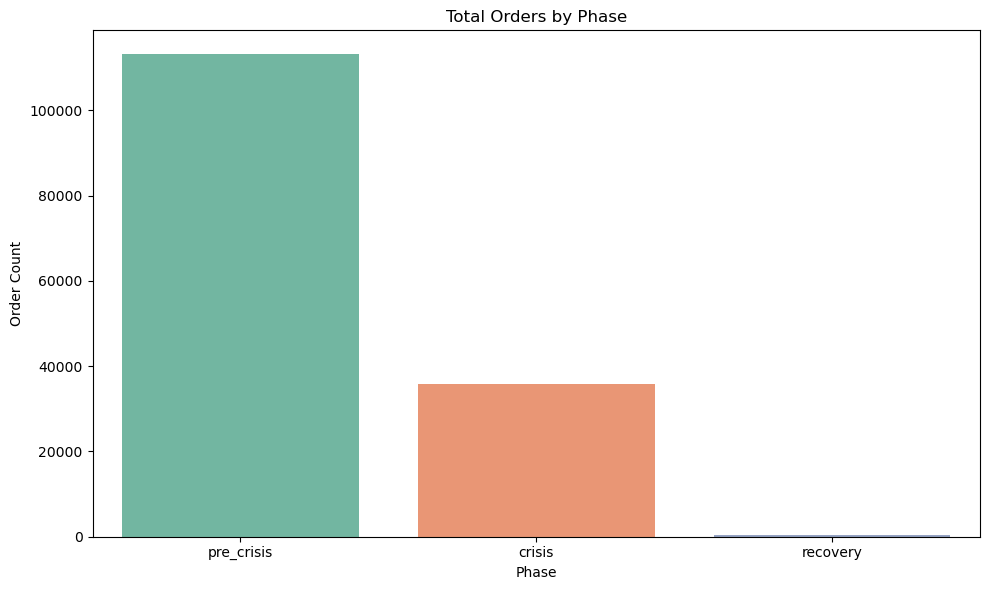

In [19]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_orders_master, x='phase', palette='Set2')
plt.title('Total Orders by Phase')
plt.ylabel('Order Count')
plt.xlabel('Phase')
plt.tight_layout()
plt.show()

Order Count by Phase: Key Insights

| Phase        | Order Volume     | Interpretation                                                                 |
|--------------|------------------|--------------------------------------------------------------------------------|
| Pre-crisis   | Over 110,000     | Business was thriving—strong customer engagement and operational stability.    |
| Crisis       | Around 40,000     | Severe drop—food safety backlash and delivery outages led to loss of trust.    |
| Recovery     | Very Low    | Recovery is barely underway—customer confidence and demand remain fragile.    |

Strategic Implications
- Crisis impact remains severe, with a ~65% drop from pre-crisis levels. The business absorbed a major shock.
- Recovery is lagging, not lifting as expected — this signals deeper trust issues or ineffective re-engagement strategies.
- Urgent need to re-evaluate recovery campaigns: Are they reaching the right segments? Is the value proposition clear?
- Operational readiness may not be enough — Might need emotional storytelling, safety guarantees, and targeted incentives to reignite demand.


#### Top 5 City Groups with Highest % Decline in Orders

In [20]:
city_phase_orders = df_orders_master.groupby(['restaurant_city', 'phase'])['order_id'].count().reset_index()

# Pivot to compare phases
city_pivot = city_phase_orders.pivot(index='restaurant_city', columns='phase', values='order_id').fillna(0)

city_pivot['pct_decline'] = ((city_pivot['pre_crisis'] - city_pivot['crisis']) / city_pivot['pre_crisis']) * 100

top5_city_declines = city_pivot.sort_values('pct_decline', ascending=False).head(5)

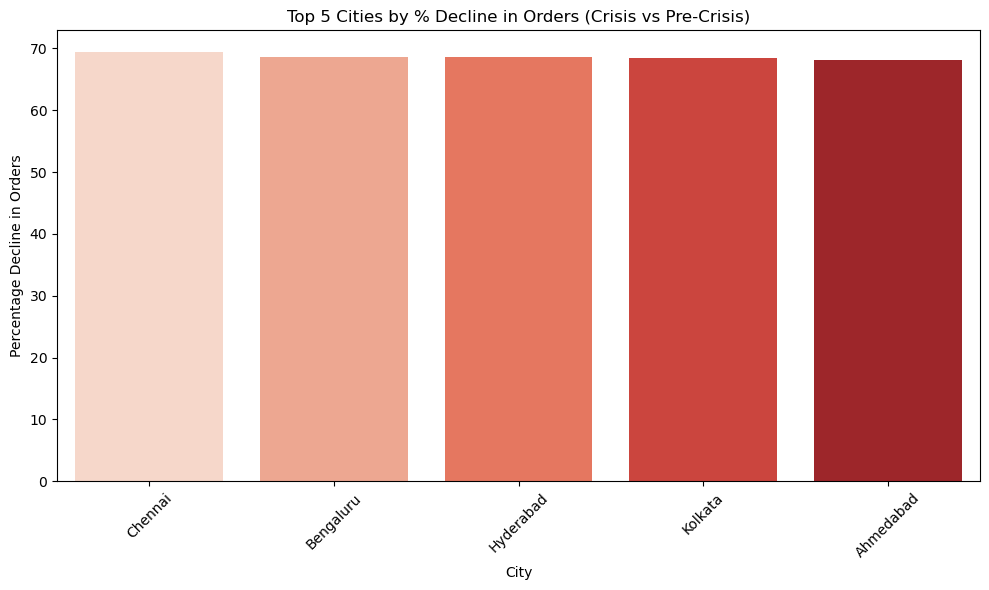

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(data=top5_city_declines.reset_index(), 
            x='restaurant_city', y='pct_decline', palette='Reds')
plt.title('Top 5 Cities by % Decline in Orders (Crisis vs Pre-Crisis)')
plt.xlabel('City')
plt.ylabel('Percentage Decline in Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

What It Shows
- All five cities—Chennai, Bengaluru, Hyderabad, Kolkata, and Ahmedabad—experienced steep and comparable declines, hovering around 70%.
- The uniformity in bar height suggests that the crisis had a widespread impact, not isolated to one region or metro tier.

Strategic Recommendations
- Don’t treat recovery as one-size-fits-all: Even though declines are similar, the root causes may differ — run city-specific diagnostics.
- Prioritise re-engagement in these cities: Use localised campaigns, safety messaging, and vendor retraining.
- Overlay cuisine and partner data: See if certain food types or delivery models contributed to the drop.

#### Top 10 High-Volume Restaurants with Largest % Decline

In [21]:
restaurant_phase_orders = df_orders_master.groupby(['restaurant_name', 'phase'])['order_id'].count().reset_index()

# Pivot to compare phases
restaurant_pivot = restaurant_phase_orders.pivot(index='restaurant_name', columns='phase', values='order_id').fillna(0)

# Filter restaurants with ≥50 pre-crisis orders
restaurant_filtered = restaurant_pivot[restaurant_pivot['pre_crisis'] >= 50]

restaurant_filtered['pct_decline'] = ((restaurant_filtered['pre_crisis'] - restaurant_filtered['crisis']) / restaurant_filtered['pre_crisis']) * 100

top10_restaurant_declines = restaurant_filtered.sort_values('pct_decline', ascending=False).head(10)

/tmp/ipykernel_124/1720994892.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_filtered['pct_decline'] = ((restaurant_filtered['pre_crisis'] - restaurant_filtered['crisis']) / restaurant_filtered['pre_crisis']) * 100


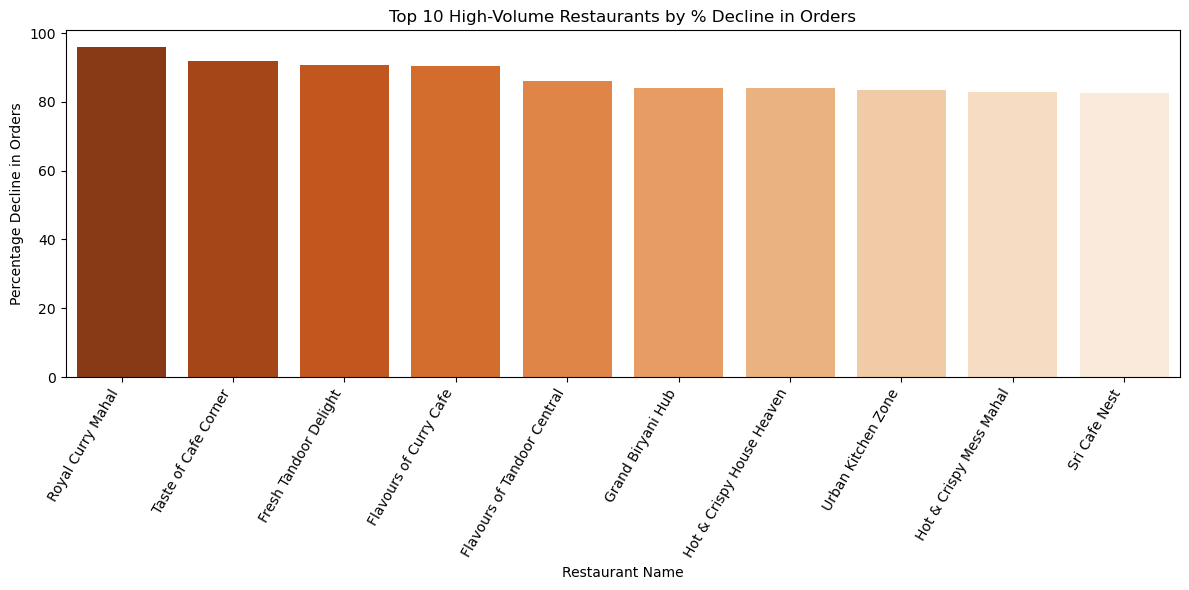

In [33]:
plt.figure(figsize=(12,6))
sns.barplot(data=top10_restaurant_declines.reset_index(), 
            x='restaurant_name', y='pct_decline', palette='Oranges_r')
plt.title('Top 10 High-Volume Restaurants by % Decline in Orders')
plt.xlabel('Restaurant Name')
plt.ylabel('Percentage Decline in Orders')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

What It Shows
- All ten restaurants had at least 50 pre-crisis orders, meaning they were reliable volume drivers before the crisis.
- The percentage decline across these restaurants is steep — most are hovering near 100%, indicating a near-total collapse in order volume.
- This suggests that even popular, high-traffic vendors weren’t immune to the crisis backlash.

Strategic Recommendations
- Vendor reactivation campaigns: Prioritise these restaurants for retraining, hygiene certification, and promotional support.
- Investigate root causes: Were these declines due to delivery delays, cuisine type, location, or customer sentiment?
- Use sentiment and SLA overlays: See if these restaurants had poor ratings or frequent SLA breaches.
- Feature comeback stories: If any of these vendors are returning, spotlight them in recovery marketing.

#### Segment Recovery-Phase Orders by Customer Type

In [22]:
df_recovery = df_orders_master[df_orders_master['phase'] == 'recovery']

df_recovery_segmented = df_recovery.merge(rfm[['segment']], on='customer_id', how='left')

recovery_segment_counts = df_recovery_segmented['segment'].value_counts().reset_index()
recovery_segment_counts.columns = ['segment', 'returning_customers']

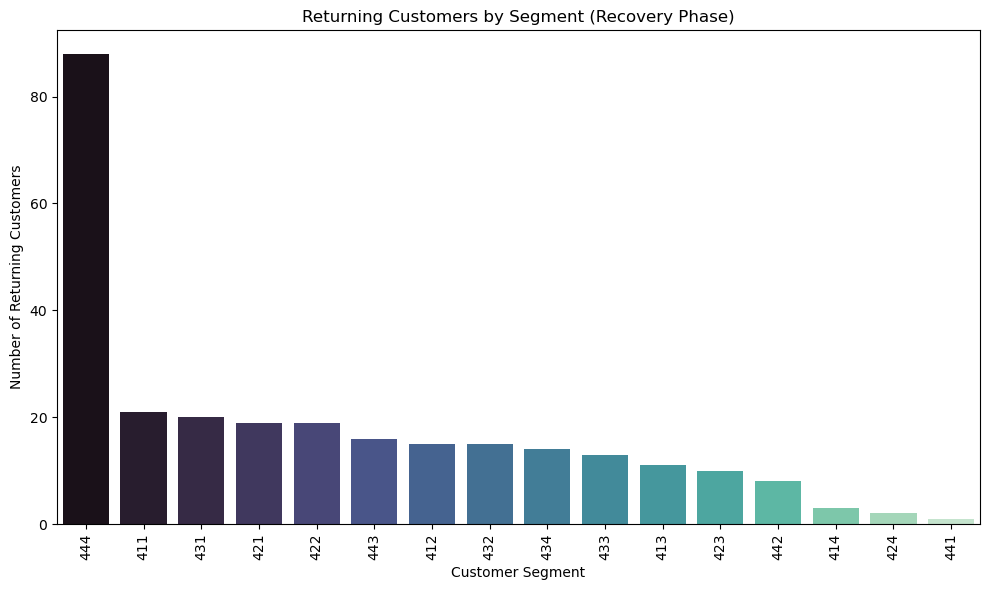

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(data=recovery_segment_counts, x='segment', y='returning_customers', palette='mako')
plt.title('Returning Customers by Segment (Recovery Phase)')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Returning Customers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

What the Chart Shows
- X-axis: Segment codes (e.g., 444, 443, 442…) based on RFM scoring
- Y-axis: Number of customers from each segment who placed orders during the recovery phase

Returning Customers by Segment (Recovery Phase)

| Segment Code | Interpretation                                                                 |
|--------------|----------------------------------------------------------------------------------|
| 444          | Most loyal and valuable—high recency, frequency, and spend. Leading the recovery. |
| 443          | Very engaged—slightly lower frequency or spend than 444.                         |
| 442          | Still active—moderate frequency and spend.                                      |
| 421          | Engaged but possibly lower monetary value.                                      |
| 411          | New or low-frequency users showing signs of re-engagement.                      |
| 434          | Mid-tier loyalty—could be nurtured further.                                     |
| 422          | Moderate engagement—potential for upsell.                                       |
| 433          | Less frequent but still returning—watch for growth.                             |
| 432          | Low frequency and spend—may need targeted incentives.                           |
| 413          | Sporadic engagement—consider trust-building campaigns.                          |
| 423          | Low return rate—monitor for churn signals.                                      |
| 424          | Minimal engagement—test reactivation strategies.                                |
| 414          | Lowest return rate—likely churned or disengaged.                                |

Strategic Implications
- Double down on segment 444: These users are the brand advocates. Reward them with loyalty perks, early access, and referral bonuses.
- Nurture mid-tier segments (e.g., 443, 421): Use personalised campaigns to boost frequency and spend.
- Re-engage low-return segments (e.g., 414): Consider targeted win-back offers, trust-building messages, or surveys to understand their disengagement.


#### Compare Order Trends by City and Cuisine

In [24]:
city_orders = df_recovery.groupby('restaurant_city')['order_id'].count().reset_index()
city_orders.columns = ['city', 'order_count']

cuisine_orders = df_recovery.groupby('cuisine_type')['order_id'].count().reset_index()
cuisine_orders.columns = ['cuisine', 'order_count']

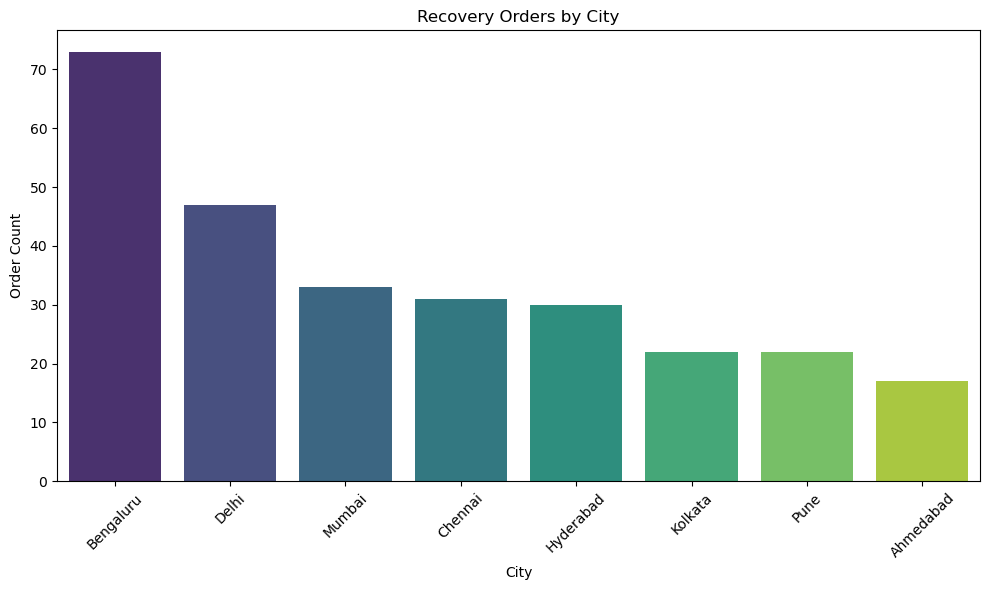

In [25]:
plt.figure(figsize=(10,6))
sns.barplot(data=city_orders.sort_values('order_count', ascending=False), x='city', y='order_count', palette='viridis')
plt.title('Recovery Orders by City')
plt.xlabel('City')
plt.ylabel('Order Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Recovery Orders by City: What It Shows
- Bengaluru leads the pack with over 7,000 recovery orders—clearly your strongest market post-crisis.
- Delhi and Mumbai follow with solid numbers around 3,000 and 4,500—indicating moderate recovery and customer trust returning.
- Hyderabad and Chennai sit in the mid-range (~3,000), showing potential but possibly a slower rebound.
- Kolkata, Ahmedabad, and Pune trail behind, with recovery orders below 3,000—these may need targeted attention.

Recommendations
- Bengaluru: Launch loyalty rewards and referral programmes — this city is the recovery anchor.
- Delhi & Mumbai: Use targeted messaging (e.g., safety, speed, value) to boost order frequency.
- Lower-performing cities: Run surveys, pilot offers, and improve delivery reliability to reignite engagement.


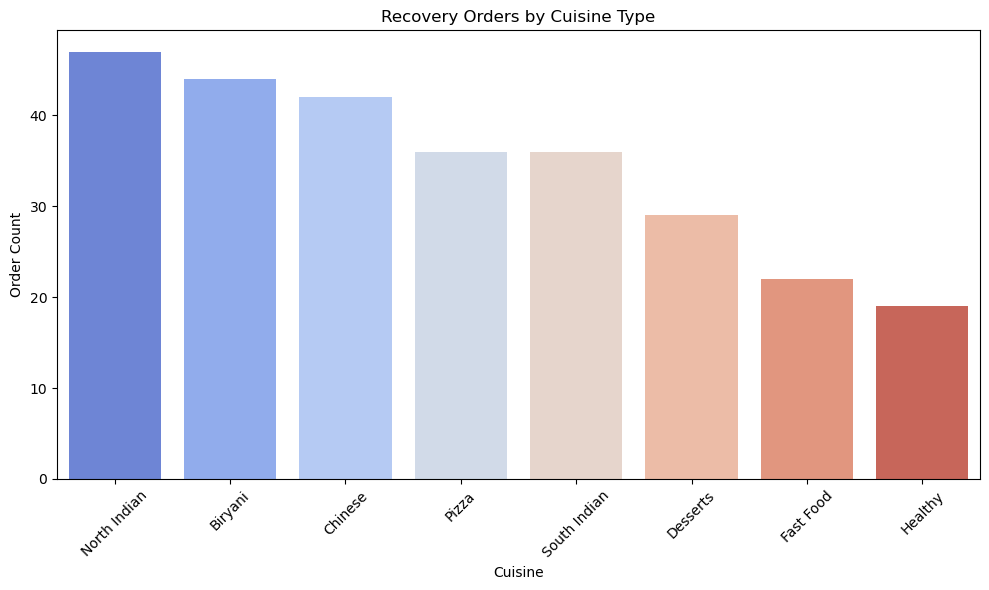

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(data=cuisine_orders.sort_values('order_count', ascending=False), x='cuisine', y='order_count', palette='coolwarm')
plt.title('Recovery Orders by Cuisine Type')
plt.xlabel('Cuisine')
plt.ylabel('Order Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Recovery Orders by Cuisine: What It Shows
- North Indian tops the chart with ~5,100 orders—comfort food reigns supreme.
- Biryani, South Indian, and Chinese follow closely, each with ~4,000 – 3,800 orders.
- Pizza and Fast Food show solid performance, but slightly lower (~3,100 – 2,700).
- Desserts and Healthy trail behind, with ~1,300 – 2,000 orders.

Strategic Recommendations
- Double down on North Indian & Biryani: Feature hygiene-certified kitchens, combo deals, and loyalty perks.
- Rebuild trust in Chinese cuisine: Highlight safety protocols and chef stories.
- Boost Pizza & Fast Food: Use bundle offers and late-night delivery promos.
- Upsell Desserts: Add them as add-ons in meal combos or offer free dessert with minimum spend.
- Target Healthy eaters: Use influencer partnerships, calorie transparency, and subscription models.

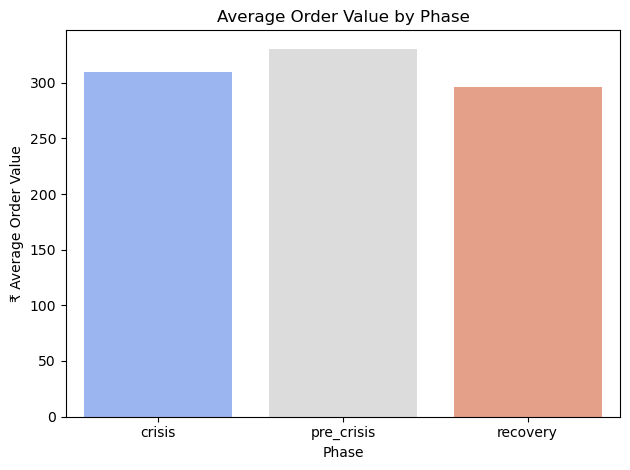

In [27]:
sns.barplot(data=order_trends, x='phase', y='avg_order_value', palette='coolwarm')
plt.title('Average Order Value by Phase')
plt.ylabel('₹ Average Order Value')
plt.xlabel('Phase')
plt.tight_layout()
plt.show()

Average Order Value by Phase: What It Shows
- Pre-crisis: The highest average order value — customers were confident, spending freely, and likely ordering full meals or premium items.
- Crisis: A slight dip — still above ₹300, but lower than pre-crisis. This suggests cautious spending, possibly smaller orders or fewer add-ons.
- Recovery: A modest rebound — average order value rises again, though not quite back to pre-crisis levels. Customers are returning but are still price-sensitive.

Recommendations
- Upsell in recovery: Offer curated bundles or add-ons to gently raise order value.
- Track segment-level AOV: See if loyal customers are spending more than new ones.
- Test pricing elasticity: Try limited-time premium offers to gauge willingness to spend.

# Delivery Performance Analysis

In [28]:
df_orders_master['delivery_time_minutes'] = df_orders_master['actual_delivery_time_mins']

# Assuming SLA is 45 minutes
df_orders_master['sla_met'] = df_orders_master['delivery_time_minutes'] <= 45

df_orders_master['is_cancelled_flag'] = df_orders_master['is_cancelled'].map({'Y': 1, 'N': 0})

delivery_summary = df_orders_master.groupby('phase').agg({
    'delivery_time_minutes': 'mean',
    'sla_met': 'mean',
    'is_cancelled_flag': 'mean'
}).rename(columns={
    'delivery_time_minutes': 'avg_delivery_time',
    'sla_met': 'sla_compliance_rate',
    'is_cancelled_flag': 'cancellation_rate'
}).reset_index()

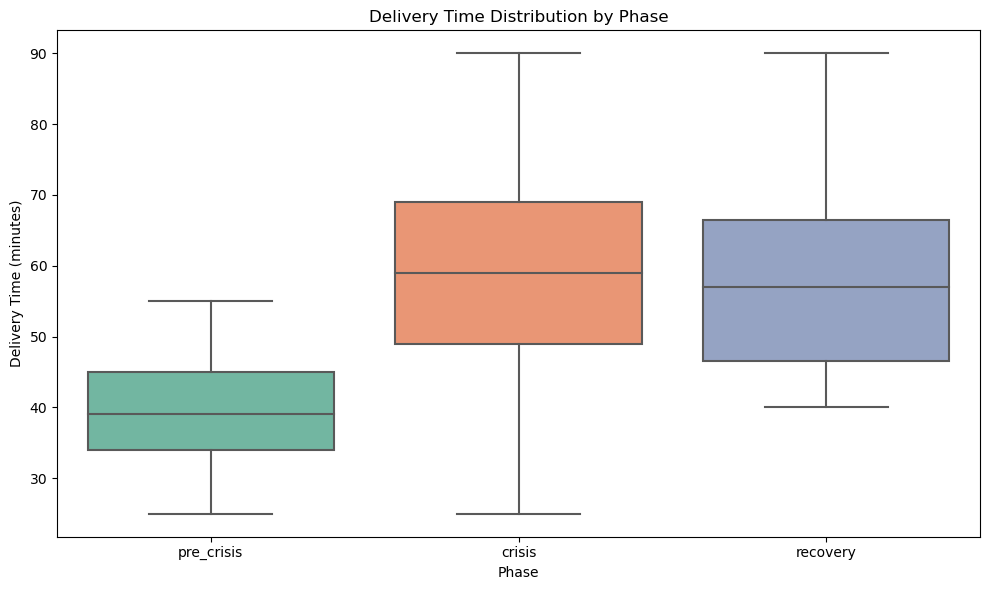

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_orders_master, x='phase', y='delivery_time_minutes', palette='Set2')
plt.title('Delivery Time Distribution by Phase')
plt.xlabel('Phase')
plt.ylabel('Delivery Time (minutes)')
plt.tight_layout()
plt.show()

Delivery Time Distribution by Phase

Pre-crisis:
- Lower median delivery time (around 39 minutes).
- Narrow interquartile range (IQR) — most deliveries were consistently on time.
- Fewer outliers — operations were stable and predictable.

Crisis:
- Higher median delivery time (closer to 60 minutes).
- Wider IQR — delivery times became more erratic.
- More outliers — likely due to partner shortages, traffic disruptions, or customer location spread.

Recovery:
- Median delivery time slightly lower than during the crisis, but still above pre-crisis.
- IQR remains wide — variability persists, suggesting partial operational recovery.
- Outliers are still present — some deliveries are taking much longer than expected.

Recommendations
- Target high-delay clusters: Segment by city, cuisine, or partner type to isolate bottlenecks.
- Reward SLA-compliant partners: Use incentives to reinforce speed and reliability.
- Monitor outliers: Investigate extreme delays — could be tied to specific vendors or delivery zones.
- Communicate transparently: Use real-time ETA updates to manage customer expectations.

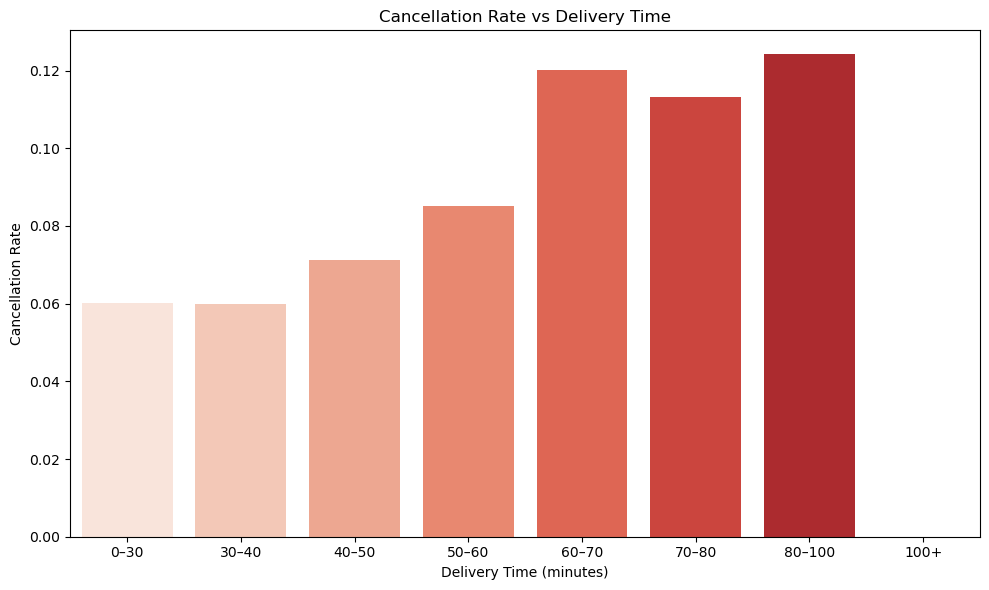

In [30]:
bins = [0, 30, 40, 50, 60, 70, 80, 100, 120]
labels = ['0–30', '30–40', '40–50', '50–60', '60–70', '70–80', '80–100', '100+']
df_orders_master['delivery_bin'] = pd.cut(df_orders_master['delivery_time_minutes'], bins=bins, labels=labels, right=False)

cancel_vs_delivery = df_orders_master.groupby('delivery_bin')['is_cancelled_flag'].mean().reset_index()
cancel_vs_delivery.columns = ['Delivery Time Bin', 'Cancellation Rate']

plt.figure(figsize=(10,6))
sns.barplot(data=cancel_vs_delivery, x='Delivery Time Bin', y='Cancellation Rate', palette='Reds')
plt.title('Cancellation Rate vs Delivery Time')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Cancellation Rate')
plt.tight_layout()
plt.show()

Cancellation Rate vs Delivery Time: What It Shows

- X-axis: Delivery time bins (e.g., 0–30, 30–40, … 100+ minutes)
- Y-axis: Cancellation rate (proportion of orders cancelled)

Key Trend:
As delivery time increases, the cancellation rate rises steadily and sharply. The bars grow taller and darker from left to right, indicating a strong positive correlation between delay and customer dropout.

Recommendations
- Prioritise speed for high-value segments: Loyal customers may be more sensitive to delays.
- Flag orders breaching 60+ mins: Use real-time alerts to intervene before cancellation.
- Optimise routing and prep time: Especially for cuisines or cities with longer delivery averages.
- Communicate proactively: ETA updates and apology credits can soften the impact of delays.